# Compresión de Imágenes usando PCA

Históricamente, uno de los primeros usos de **PCA** en el área de procesamiento de imágenes fue como método de compresión. 

Si tenemos una imagen de tamaño $H \times W $ píxeles, esta se subdivide en bloques de $C \times C $ píxeles (por ejemplo, tomar $C $ un factor común de las dimensiones $H $ y $W $ de la imagen). Con los valores de los píxeles en cada bloque se forma un vector:

$$
\mathbf{b}_i = (x_1, x_2, \dots, x_{c^2}) \in \mathbb{R}^{c^2}
$$

La matriz de datos se forma con todos estos vectores provenientes de los bloques $i $ vectorizados. 

La **compresión** consiste en proyectar los datos sobre los primeros $k $ componentes principales, mientras que la **descompresión** consiste en reconstruir la imagen a su tamaño original $H \times W $ a partir de estas proyecciones.

## Implementación

Se implementará lo anterior para varias imágenes (en escala de grises o a color) y mostrar el efecto del valor de $k $ sobre la calidad de la reconstrucción. 

- Se Analizará cómo cambia el **error de reconstrucción** y la **calidad visual** a medida que se incrementa o disminuye $k $.
- Se mostrará los resultados obtenidos de al menos **3 imágenes**.


### Importacion de librerias a utilizar

In [803]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

### Obtener las imágenes originales y mostrarlas

In [804]:
"""
Carga una lista de imágenes en formato RGB.

@param path_list (list[str]): Lista de rutas de imágenes a cargar.
@return (list[np.ndarray]): Lista de imágenes cargadas como NumPy arrays con canales RGB.
"""
def loadImages(path_list):
    images_rgb = [mpimg.imread(path_list[i])[:, :, :3] for i in range(len(path_list))]
    return images_rgb

In [805]:
ruta_principal = "./images/"
n_images = ["compress1.png","compress2.jpg","compress3.png"]
n_images = [f"{ruta_principal}{n_images[i]}" for i in range(len(n_images))]
images = loadImages(path_list=n_images)

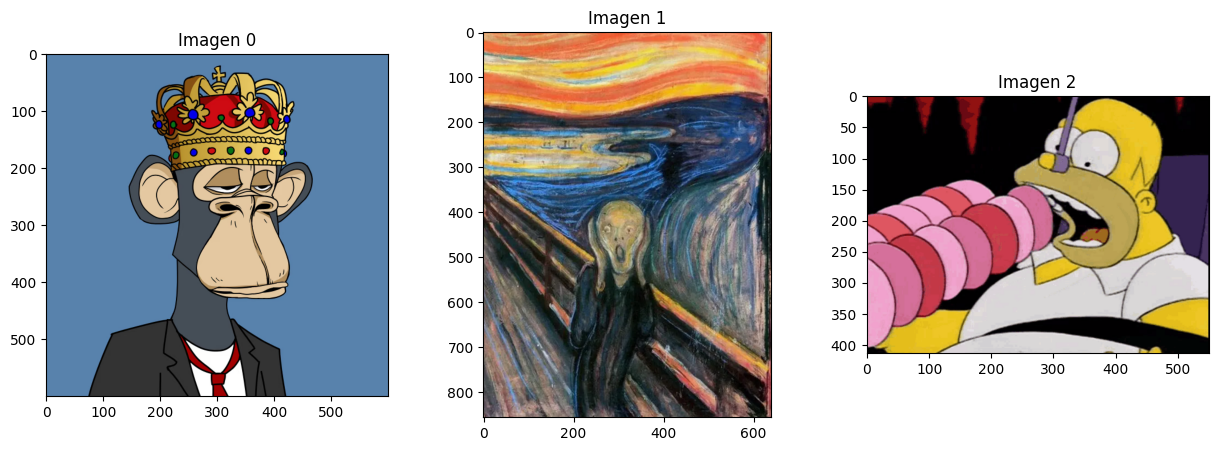

In [806]:
_, axs = plt.subplots(nrows=1, ncols=len(images), figsize=(15, 5))

for i in range(len(images)):
    axs[i].imshow(images[i])
    axs[i].set_title(f"Imagen {i}")

plt.show()

### Centralización de datos

Este paso es fundamental en el Análisis de Componentes Principales (PCA) para evitar que las variables con valores más grandes tengan un peso desproporcionado en el análisis. En el caso de imágenes, la estandarización se puede aplicar a los colores, tanto por filas como por columnas, utilizando NumPy de manera sencilla y la sintaxis para ejes `axis=(0,1)`:

- Realiza la operación (media y desviación estándar) de cada canal en toda la imagen.
- Para este caso es un vector de 3 valores que contiene ya sea la media o desviación estándar de cada canal (RGB).

In [807]:
"""
Estandariza una imagen normalizando sus valores con la media y desviación estándar.

@param data (np.ndarray): Imagen en formato NumPy array con canales RGB.
@return (tuple[np.ndarray, np.ndarray, np.ndarray]): Imagen estandarizada, media y desviación estándar por canal.
"""
def standardizeData(data):
  mu = data.mean(axis=(0,1))
  std = data.std(axis=(0,1))
  data_standar = (data - mu) / std
  return data_standar, mu, std


### **Compresión y Descompresión**  

Dado que las imágenes se manejan en color y no en escala de grises (lo que implicaría un cálculo y aplicación más sencilla), el conjunto de datos tendrá un tamaño de $ (h, w, 3) $. Esto significa que cada imagen en el dataset contará con $ h $ filas y $ w $ columnas, donde cada posición de la matriz representa un píxel. A su vez, cada píxel está asociado a un vector de tamaño $ 1 \times 3 $, que almacena los valores de color en el formato RGB.  

Por lo tanto, la compresión no se realizará de la forma $ X_k = X_c @ (V[:k,:].T) $, ya que en este caso la descomposición no se aplica sobre toda la matriz, sino sobre las matrices que conforman cada canal de color. Se realiza **SVD** por separado para cada canal **R, G y B**, y posteriormente se lleva a cabo la descompresión en cada uno.  

Si se aplicara la descomposición sobre toda la matriz general, los colores se mezclarían, por lo que es necesario realizar la compresión de forma independiente para cada píxel, considerando que este se compone de tres valores de color, a diferencia de una imagen en escala de grises, que solo tiene una intensidad en una matriz bidimensional.  

Luego de realizar la compresión, se obtienen los $ k $ componentes principales (descompresión) de cada canal de color, y finalmente se vuelven a unir mediante `np.stack()`. Esto permite reconstruir la matriz en un formato tridimensional, donde los colores se organizan correctamente en la **tercera dimensión** (`axis=2`), obteniendo nuevamente una matriz de tamaño $ (h, w, 3) $ para su visualización.

In [808]:
"""
Aplica la Descomposición en Valores Singulares (SVD) a una imagen y la reconstruye con los primeros k componentes.

@param data (np.ndarray): Imagen en formato NumPy array con canales RGB.
@param std (np.ndarray): Desviación estándar utilizada en la normalización.
@param mu (np.ndarray): Media utilizada en la normalización.
@param k (int): Número de componentes principales a utilizar en la reconstrucción.

@return (np.ndarray): Imagen reconstruida con los primeros k componentes principales.
"""
def doSVD(data, std, mu, k):
  U_r, S_r, Vt_r = np.linalg.svd(data[:,:,0], full_matrices=False)
  U_g, S_g, Vt_g = np.linalg.svd(data[:,:,1], full_matrices=False)
  U_b, S_b, Vt_b = np.linalg.svd(data[:,:,2], full_matrices=False)

  # Reconstrucción de cada canal con k componentes
  R_recon = U_r[:, :k] @ np.diag(S_r[:k]) @ Vt_r[:k, :]
  G_recon = U_g[:, :k] @ np.diag(S_g[:k]) @ Vt_g[:k, :]
  B_recon = U_b[:, :k] @ np.diag(S_b[:k]) @ Vt_b[:k, :]
  
  # Unir los canales reconstruidos
  image_recon = np.stack([R_recon, G_recon, B_recon], axis=2)

  # Deshacer la estandarización (revertir el escalado)
  image_recon = (image_recon * std) + mu

  # Asegurar que los valores están en el rango [0, 1]
  image_recon = np.clip(image_recon, 0, 1)
  
  return image_recon

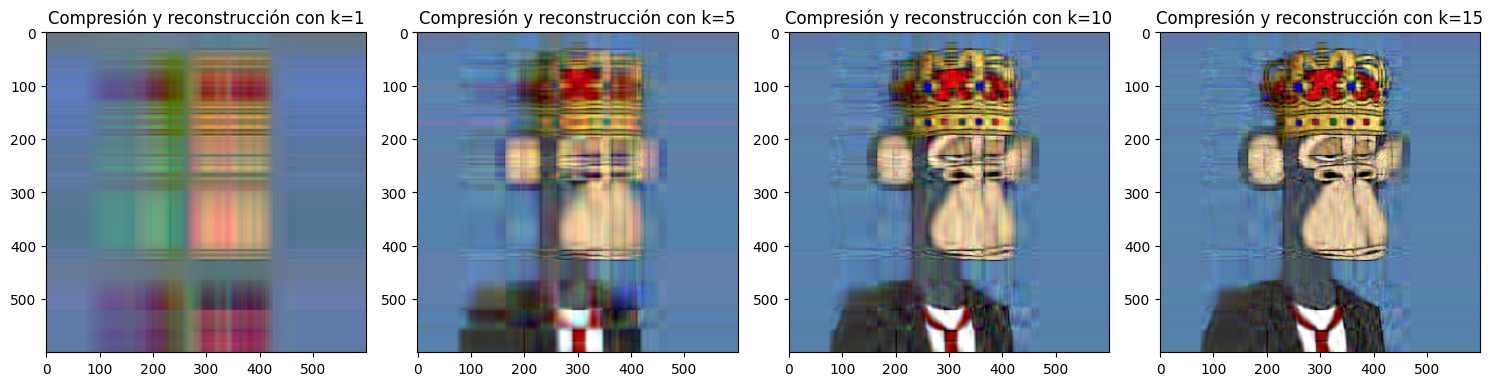

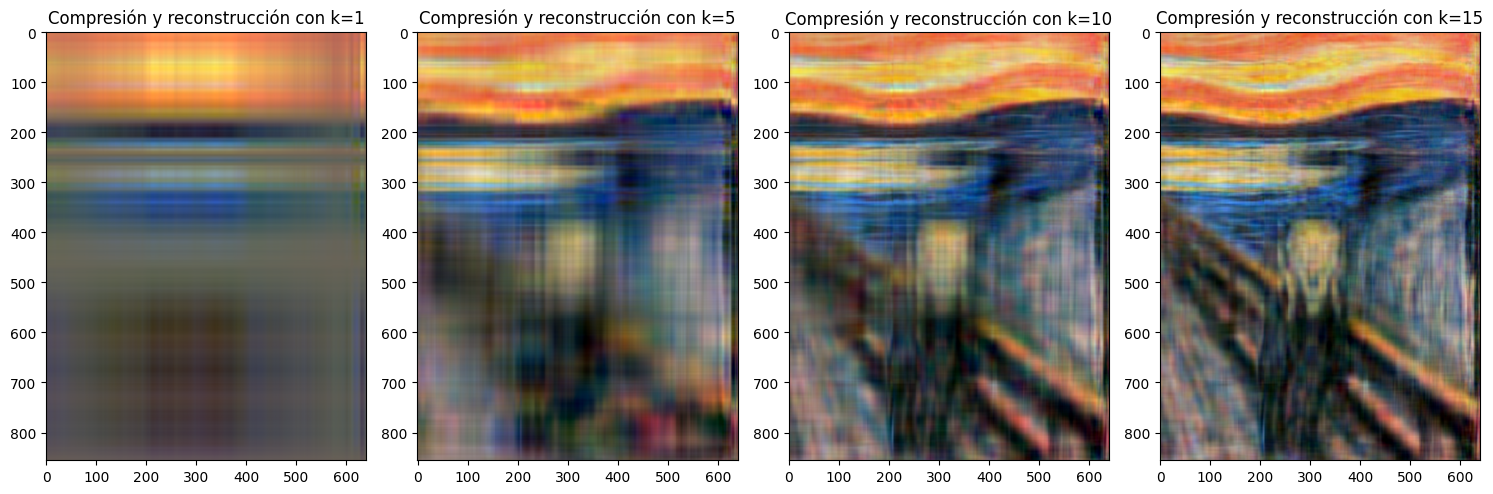

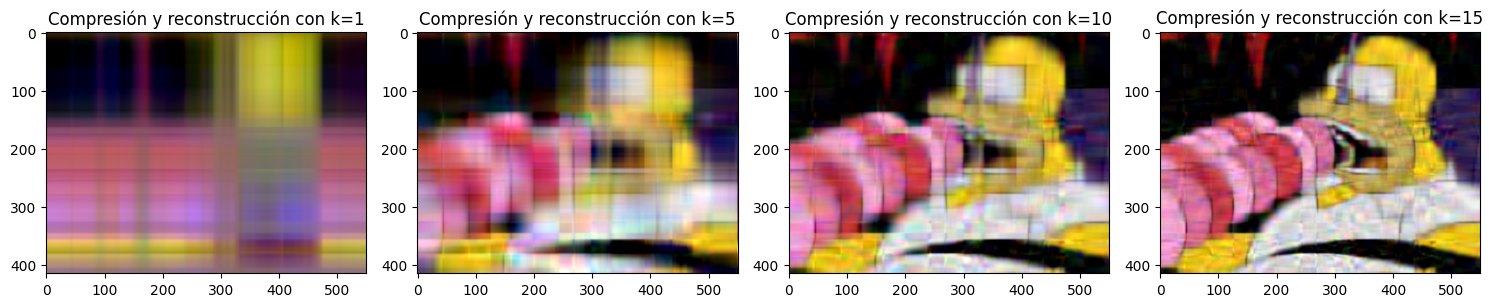

In [809]:

ver_prints = False
k = [1, 5, 10, 15]

for i in range(len(images)):
    # Mostrar datos de la imagen
    X = images[i]
    Xc, mu, std = standardizeData(data=X)

    # Crear una fila de subgráficos con tantas columnas como valores de k
    fig, axs = plt.subplots(1, len(k), figsize=(15, 5))  # Ajusta el tamaño si es necesario

    for j in range(len(k)):
        Xc_k = doSVD(data=Xc, mu=mu, std=std, k=k[j])

        if ver_prints:
            print("Data Set:\n", X, "\n")
            print("Tamaño de datos:\n", X.shape, "\n")
            print("Tipo de Set de Datos:\n", type(X), "\n")
            print("Vector de medias:\n", Xc.mean(axis=(0,1)), "\n")
            print("Vector de Dvst:\n", Xc.std(axis=(0,1)), "\n")
            print("Data Set Normalizado:\n", Xc, "\n")

        # Mostrar la imagen reconstruida en la subgráfica correspondiente
        axs[j].imshow(Xc_k)
        # axs[j].axis("off")
        axs[j].set_title(f"Compresión y reconstrucción con k={k[j]}")

    plt.tight_layout()  # Ajusta el espacio entre subgráficos
    plt.show()  # Mostrar todas las imágenes en una sola fila
